In [16]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets

import matplotlib.pyplot as plt
import numpy as np

In [20]:
transform = transforms.Compose([
        transforms.Resize((32, 32)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]
)

train_dir = './ImageEmotionDatasetMid/train'
train_dataset = datasets.ImageFolder(train_dir, transform=transform)

train_dataset.classes

['amusement', 'awe', 'contentment', 'excitement', 'sadness']

In [21]:
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=2)

In [22]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)  # in channel: 3, out channel: 6, kernel size: 5, output size: 28
        self.pool = nn.MaxPool2d(2, 2)  # size 14
        self.conv2 = nn.Conv2d(6, 16, 5)  # in: 6, out: 16, kernel: 5, output size: 10
        # self.pool again, size 5
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        
    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.pool(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = self.pool(x)
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
        
net = Net()

In [23]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

In [25]:
epochs = 50

for epoch in range(epochs):
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        
        optimizer.zero_grad()
        
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        # stats
        running_loss += loss.item()
    
    # end of epoch
    print(f'Epoch {epoch} - loss: {running_loss}')

print('Finished training')

Epoch 0 - loss: 80.4298586845398
Epoch 1 - loss: 77.50597900152206
Epoch 2 - loss: 73.64729934930801
Epoch 3 - loss: 71.42421662807465
Epoch 4 - loss: 68.16079822182655
Epoch 5 - loss: 64.7278288602829
Epoch 6 - loss: 61.95002228021622
Epoch 7 - loss: 57.252868473529816
Epoch 8 - loss: 54.784678012132645
Epoch 9 - loss: 46.57884230837226
Epoch 10 - loss: 41.52404676750302
Epoch 11 - loss: 34.58390332758427
Epoch 12 - loss: 32.69490644335747
Epoch 13 - loss: 25.054055124521255
Epoch 14 - loss: 20.09164310246706
Epoch 15 - loss: 22.135679356055334
Epoch 16 - loss: 13.098901857272722
Epoch 17 - loss: 10.304568413645029
Epoch 18 - loss: 7.4331253338605165
Epoch 19 - loss: 5.582169453584356
Epoch 20 - loss: 2.7078596958658636
Epoch 21 - loss: 2.145105203613639
Epoch 22 - loss: 1.5484713953919709
Epoch 23 - loss: 1.2439634518232197
Epoch 24 - loss: 0.872355937026434
Epoch 25 - loss: 0.645902048330754
Epoch 26 - loss: 0.4110079776728526
Epoch 27 - loss: 0.3292241853196174
Epoch 28 - loss: 0.1

In [26]:
save_dir = './test_model.pth'
torch.save(net.state_dict(), save_dir)

In [27]:
test_dir = './ImageEmotionDatasetMid/test'
test_dataset = datasets.ImageFolder(test_dir, transform=transform)

test_dataset.classes

['amusement', 'awe', 'contentment', 'excitement', 'sadness']

In [31]:
# copied this from the sample lol
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

In [37]:
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=True, num_workers=2)

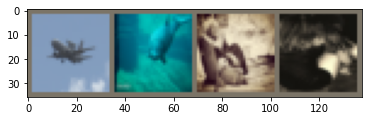

Ground Truth:    awe   awe contentment sadness


In [38]:
dataiter = iter(test_loader)

images, labels = dataiter.next()
imshow(torchvision.utils.make_grid(images))
print('Ground Truth: ', ' '.join('%5s' % test_dataset.classes[labels[j]] for j in range(4)))

In [39]:
with torch.no_grad():
    outputs = net(images)
    _, predicted = torch.max(outputs, 1)
    print('Predicted: ', ' '.join('%5s' % test_dataset.classes[predicted[j]] for j in range(4)))

Predicted:    awe   awe excitement sadness


In [41]:
correct = 0
total = 0
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on all test images: %d %%' % (100 * correct / total))

Accuracy of the network on all test images: 30 %


In [43]:
correct = 0
total = 0
with torch.no_grad():
    for data in train_loader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on all train images: %d %%' % (100 * correct / total))

Accuracy of the network on all train images: 100 %


lmao completely overfitted